In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path

from sklearn.model_selection import train_test_split

import tensorflow as tf

from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

In [ ]:
from tensorflow.keras.preprocessing import image

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

In [ ]:
import keras
from keras.utils.np_utils import to_categorical

In [ ]:
image_dir = Path('../content/drive/MyDrive/fruitbox1')

In [ ]:
#filepaths = (pd.Series(list(image_dir.glob(r'**/*.jpg')), name='Filepath')).astype(str)
#ages = pd.Series(filepaths.apply(lambda x: os.path.split(os.path.split(x)[0])[1]), name='Age').astype(np.int)
ages = pd.read_csv('/content/drive/MyDrive/csvsave.csv')
images = pd.concat([ages], axis=1).sample(frac=1.0, random_state=1).reset_index(drop=True)

In [ ]:
# Let's only use 5000 images to speed up training time
#image_df = images.sample(50, random_state=1).reset_index(drop=True)

train_df, test_df = train_test_split(images, train_size=0.7, shuffle=True, random_state=1)

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

In [ ]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='weight',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=8,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='weight',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=8,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='weight',
    target_size=(120, 120),
    color_mode='rgb',
    class_mode='raw',
    batch_size=8,
    shuffle=False
)

Found 602 validated image filenames.
Found 150 validated image filenames.
Found 321 validated image filenames.


/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:991: UserWarning: Found 1 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  n_invalid, x_col))
/usr/local/lib/python3.7/dist-packages/keras/preprocessing/image.py:991: UserWarning: Found 2 invalid image filename(s) in x_col="filepath". These filename(s) will be ignored.
  n_invalid, x_col))


In [ ]:
model = Sequential()
model.add(ResNet50(include_top=True, weights='imagenet', input_shape=(224, 224, 3), pooling='avg'))
model.add(Dense(1, activation='relu'))
model.summary()

102967424/102967424 [==============================] - 5s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 1000)              25636712  
                                                                 
 dense (Dense)               (None, 1)                 1001      
                                                                 
Total params: 25,637,713
Trainable params: 25,584,593
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
model.compile(
    optimizer='adam',
    loss='mse',

)

history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=100,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/100
76/76 [==============================] - 635s 8s/step - loss: 4.8694 - val_loss: 4.5184
Epoch 2/100
76/76 [==============================] - 136s 2s/step - loss: 4.3002 - val_loss: 4.1478
Epoch 3/100
76/76 [==============================] - 133s 2s/step - loss: 3.8328 - val_loss: 3.4783
Epoch 4/100
76/76 [==============================] - 133s 2s/step - loss: 3.4322 - val_loss: 3.1120
Epoch 5/100
76/76 [==============================] - 133s 2s/step - loss: 3.0873 - val_loss: 2.8009
Epoch 6/100
76/76 [==============================] - 133s 2s/step - loss: 2.7904 - val_loss: 2.5307
Epoch 7/100
76/76 [==============================] - 134s 2s/step - loss: 2.5411 - val_loss: 2.3042
Epoch 8/100
76/76 [==============================] - 133s 2s/step - loss: 2.3310 - val_loss: 2.1139
Epoch 9/100
76/76 [==============================] - 133s 2s/step - loss: 2.1538 - val_loss: 1.9591
Epoch 10/100
76/76 [==============================] - 132s 2s/step - loss: 2.0056 - val_loss: 1.8271

In [ ]:
predicted_weight = np.squeeze(model.predict(test_images))
true_ages = test_images.labels

mse = model.evaluate(test_images, verbose=0)
print("     Test MSE: {:.5f}".format(mse))

r2 = r2_score(true_ages, predicted_weight)
print("Test R^2 Score: {:.5f}".format(r2))

41/41 [==============================] - 268s 7s/step
     Test MSE: 1.40612
Test R^2 Score: -0.00252


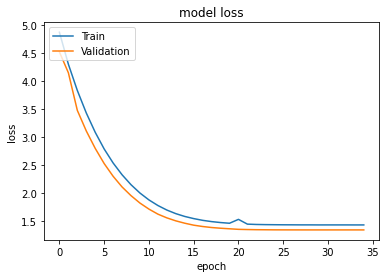

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
img="/content/drive/MyDrive/fruitbox1/Image_110.jpg"

img1 = image.load_img(img, target_size=(224, 224,3))
img_array = image.img_to_array(img1)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)

In [ ]:
y=model.predict(img_preprocessed)

1/1 [==============================] - 0s 21ms/step


In [ ]:
print(y)

[[0.]]


In [ ]:
model.save('/content/drive/MyDrive/model/latestrlu.h5')

In [ ]:
model.load_weights('/content/drive/MyDrive/model/new2.h5')